In [178]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO, BytesIO
import zipfile
import requests
from collections import Counter
import seaborn as sns
from scipy import stats


In [179]:
#Download zip
r = requests.get("https://snap.stanford.edu/data/twitch_gamers.zip")
archive = zipfile.ZipFile(BytesIO(r.content), 'r')

In [180]:
#Load rawdata

twitch_rawdata_edges = StringIO(str(archive.read('large_twitch_edges.csv'), 'utf-8'))
twitch_rawdata_feature = StringIO(str(archive.read('large_twitch_features.csv'), 'utf-8'))

twitch_raw_data_df_feature = pd.read_csv(twitch_rawdata_feature, sep=",")
twitch_raw_data_df_edges = pd.read_csv(twitch_rawdata_edges, sep=",")

In [181]:
#Get only polish streamers

twitch_filter_PL = twitch_raw_data_df_feature["language"] == "PL"
twitch_df_feature = twitch_raw_data_df_feature[twitch_filter_PL]

twitch_filter_edges = twitch_raw_data_df_edges["numeric_id_1"].isin(twitch_df_feature["numeric_id"])
twitch_filter_edges2 = twitch_raw_data_df_edges["numeric_id_2"].isin(twitch_df_feature["numeric_id"])
twitch_filter_edges_pair = twitch_filter_edges & twitch_filter_edges2
twitch_df_edges = twitch_raw_data_df_edges[twitch_filter_edges_pair]

In [182]:
#twitch_df_feature.to_csv(rf"D:\Dominik\Desktop\Studia\10semestr\Analiza_i_eksploracja_sieci_społecznościowych\twitch_gamers\test.csv")
twitch_df_edges.to_csv(rf"D:\Dominik\Desktop\Studia\10semestr\Analiza_i_eksploracja_sieci_społecznościowych\twitch_gamers\test2.csv")

In [183]:
#Create graph

twitch_graph = nx.from_pandas_edgelist(twitch_df_edges, 'numeric_id_1', 'numeric_id_2')

for index, node in twitch_df_feature.iterrows():
    twitch_graph.add_node(node["numeric_id"], 
                          views=node["views"],
                          mature=node["mature"],
                          life_time=node["life_time"],
                          created_at=node["created_at"],
                          updated_at=node["updated_at"],
                          dead_account=node["dead_account"],
                          language=node["language"],
                          affiliate=node["affiliate"])

In [184]:
print(twitch_graph)

Graph with 944 nodes and 8959 edges


In [185]:
degree_sequence = sorted((d for n, d in twitch_graph.degree()), reverse=True)

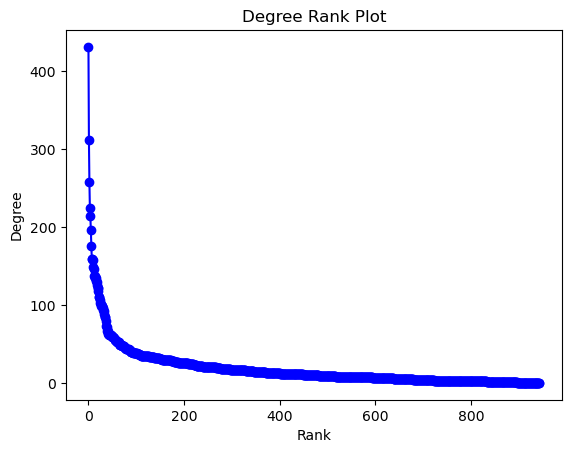

In [186]:
plt.plot(degree_sequence, "b-", marker="o")
plt.title("Degree Rank Plot")
plt.xlabel("Rank")
plt.ylabel("Degree")
plt.show()

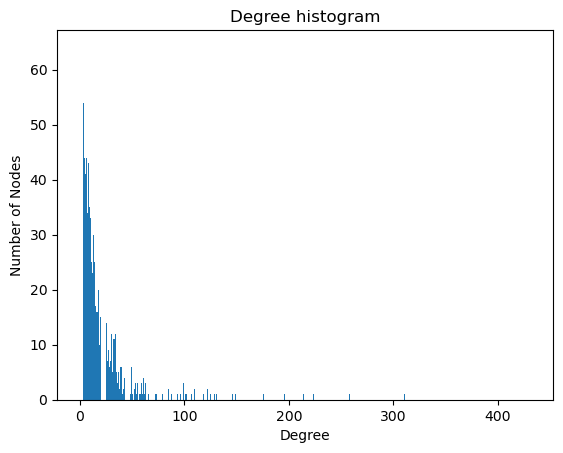

In [187]:
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

In [188]:
p = dict(nx.shortest_path_length(twitch_graph))
p_df = pd.json_normalize(p, sep='_')
p_flat = p_df.to_dict(orient='records')[0]

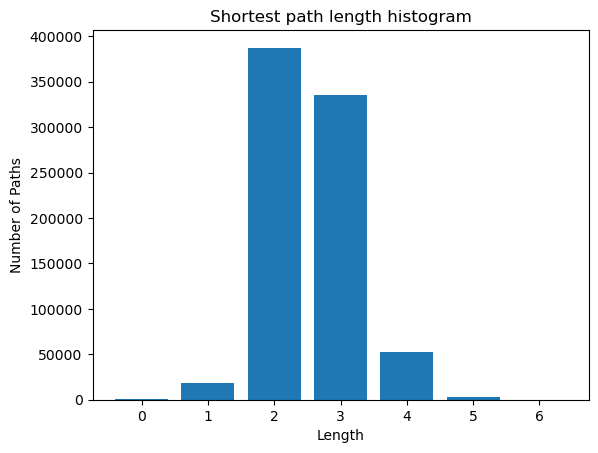

In [189]:
plt.bar(*np.unique(list(p_flat.values()), return_counts=True))
plt.title("Shortest path length histogram")
plt.xlabel("Length")
plt.ylabel("Number of Paths")
plt.show()

In [190]:
centr = nx.betweenness_centrality(twitch_graph)

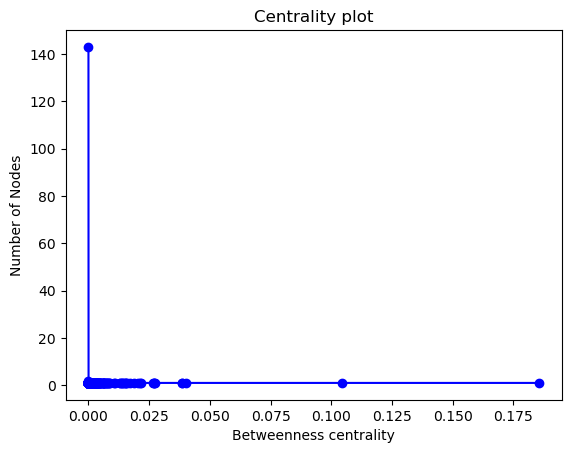

In [191]:
plt.plot(*np.unique(list(centr.values()), return_counts=True), "b-", marker="o")
plt.title("Centrality plot")
plt.xlabel("Betweenness centrality")
plt.ylabel("Number of Nodes")
plt.show()

In [192]:
clusters = nx.clustering(twitch_graph)

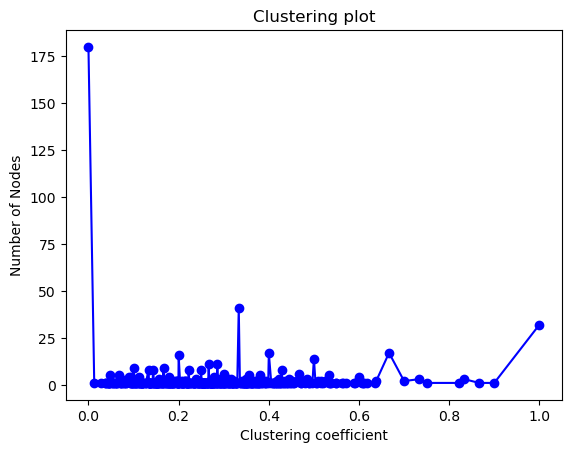

In [193]:
plt.plot(*np.unique(list(clusters.values()), return_counts=True), "b-", marker="o")
plt.title("Clustering plot")
plt.xlabel("Clustering coefficient")
plt.ylabel("Number of Nodes")
plt.show()

In [194]:
dens = nx.density(twitch_graph)
print(dens)

0.02012824199723206


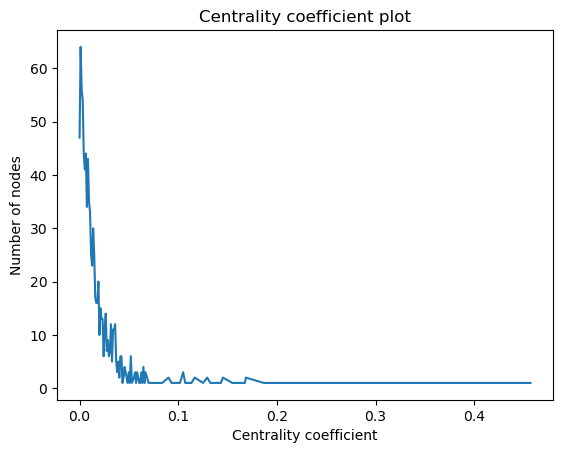

In [195]:
degree_centrality_list = list(nx.degree_centrality(twitch_graph).values())
#print(np.sort(degree_centrality_list))

plt.plot(*np.unique(degree_centrality_list, return_counts=True))
plt.title("Centrality coefficient plot")
plt.xlabel("Centrality coefficient")
plt.ylabel("Number of nodes")
plt.show()

In [196]:
if not nx.is_connected(twitch_graph):
    twitch_graph_connected_list = max(nx.connected_components(twitch_graph), key=len)
    twitch_graph_connected = twitch_graph.subgraph(twitch_graph_connected_list) 
else:
    twitch_graph_connected = twitch_graph

#print(twitch_graph)
#print(twitch_graph_connected)

radius = nx.radius(twitch_graph_connected)
print(radius)

4


In [197]:
communities = nx.algorithms.community.greedy_modularity_communities(twitch_graph, weight='weight')

In [198]:
colors = range(len(communities))

node_color_map = {}
for i, community in enumerate(communities):
    for node in community:
        node_color_map[node] = colors[i]

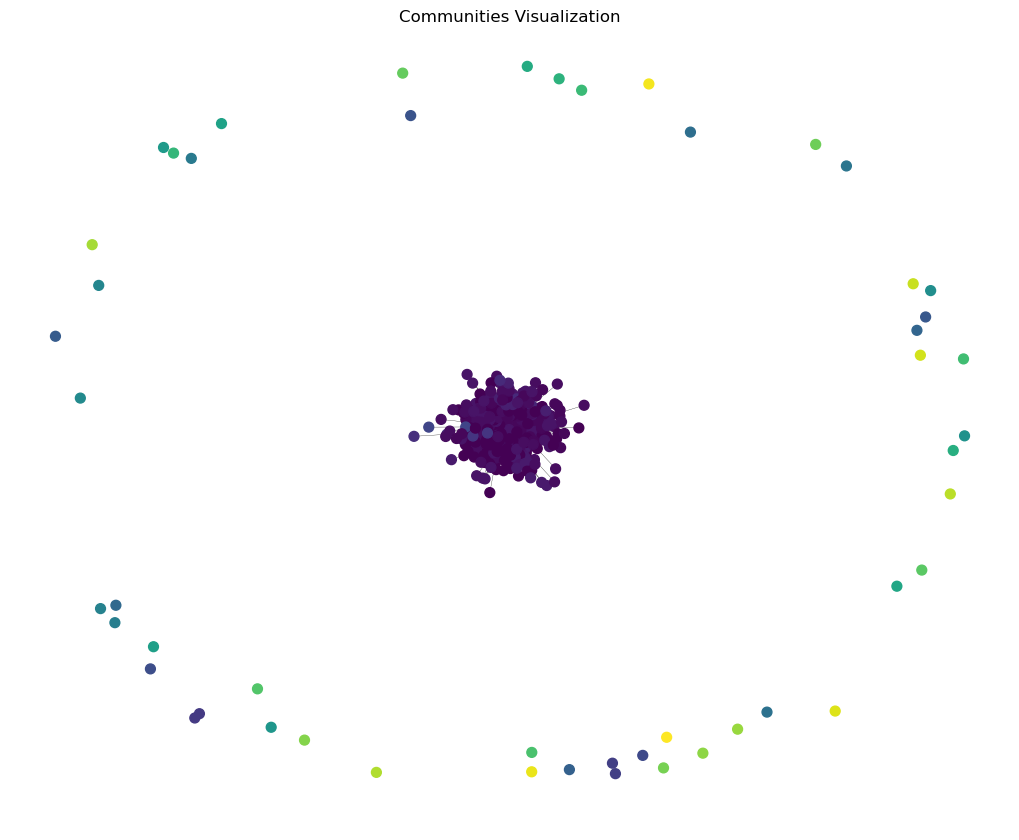

In [199]:
plt.figure(figsize=(10, 8))
pos = nx.layout.spring_layout(twitch_graph)
nx.draw(
    twitch_graph, 
    pos, 
    node_color=[node_color_map[node] for node in twitch_graph.nodes()], 
    with_labels=False, 
    node_size=50,
    width=0.2
)
plt.title('Communities Visualization')
plt.show()

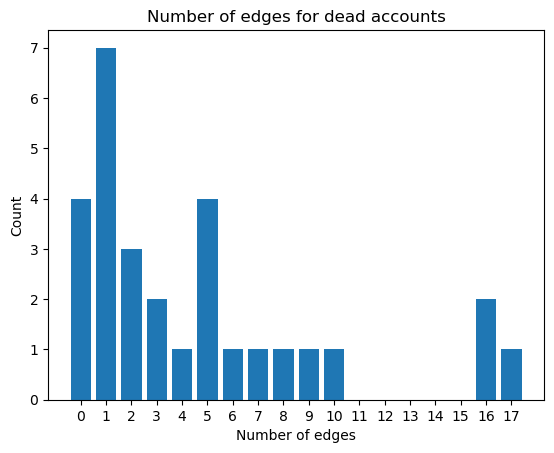

In [200]:
nodes_dead_account = [node for node, attr in twitch_graph.nodes(data=True) if attr.get('dead_account') == 1]

nodes_dead_account_degree = {node: twitch_graph.degree(node) for node in nodes_dead_account}

counts = Counter(nodes_dead_account_degree.values())

#print(nodes_dead_account_degree)
#print(counts)

labels, values = zip(*Counter(counts).items())
indexes = np.arange(len(labels))

min_value = np.min(labels)
max_value = np.max(labels)

plt.bar(labels, values)
plt.xticks(range(min_value, max_value+1))
plt.title("Number of edges for dead accounts")
plt.xlabel("Number of edges")
plt.ylabel("Count")
plt.show()

-0.08657570447771053
0.007779875160392916


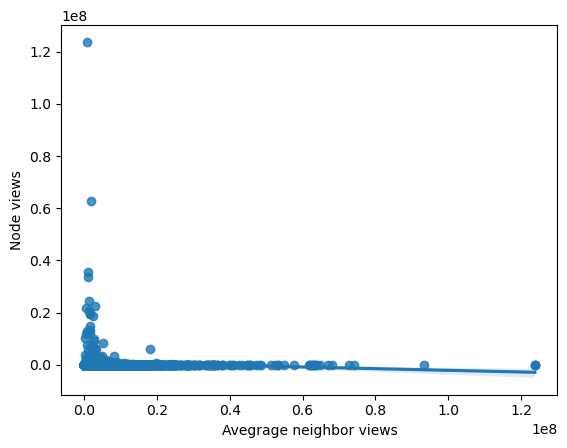

In [201]:
df = pd.DataFrame(columns=['avg_neighbor_views', 'node_views'])
for node in twitch_graph.nodes():
    count_nodes = 0
    sum_views = 0
    for neighbor in twitch_graph.neighbors(node):
        count_nodes += 1
        sum_views += twitch_graph.nodes[neighbor].get('views')

    if count_nodes == 0:
        avg_views = 0
    else:
        avg_views = sum_views/count_nodes

    df.loc[len(df.index)] = [avg_views, twitch_graph.nodes[node].get('views')]

#q_low = df["avg_neighbor_views"].quantile(0.01)
#q_hi  = df["avg_neighbor_views"].quantile(0.99)
#df_filtered = df[(df["avg_neighbor_views"] < q_hi) & (df["avg_neighbor_views"] > q_low)]

#q_low = df_filtered["node_views"].quantile(0.01)
#q_hi  = df_filtered["node_views"].quantile(0.99)
#df_filtered = df_filtered[(df["node_views"] < q_hi) & (df_filtered["node_views"] > q_low)]

sns.regplot(x="avg_neighbor_views", y="node_views", data=df)
plt.xlabel("Avegrage neighbor views")
plt.ylabel("Node views")

pearson_coef, p_value = stats.pearsonr(df['avg_neighbor_views'], df['node_views'])
print(pearson_coef)
print(p_value)

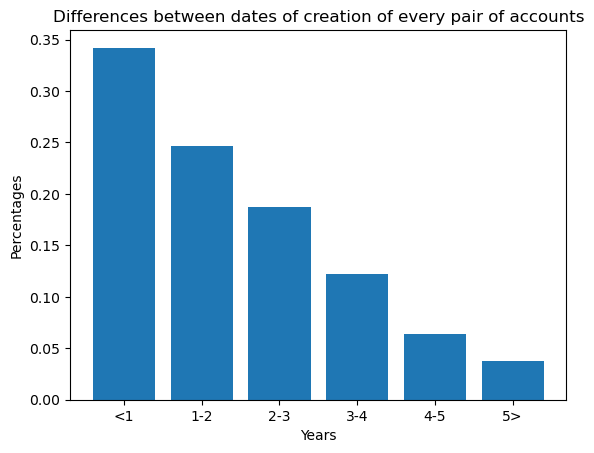

In [202]:
#<1, 1-2, 2-3, 3-4, 4-5, 5>
differences = [0, 0, 0, 0, 0, 0]
for n1, n2, a in twitch_graph.edges(data=True):
    difference = np.datetime64(twitch_graph.nodes[n1]["created_at"]) - np.datetime64(twitch_graph.nodes[n2]["created_at"])
    difference_number = abs(int(difference/ np.timedelta64(1,'D')))
    if difference_number < 365:
        differences[0] += 1
    elif 365 <= difference_number < 730:
        differences[1] += 1
    elif 730 <= difference_number < 1095:
        differences[2] += 1
    elif 1095 <= difference_number < 1460:
        differences[3] += 1
    elif 1460 <= difference_number < 1825:
        differences[4] += 1
    elif difference_number >=1825:
        differences[5] += 1
differences = [difference/sum(differences) for difference in differences]
plt.bar(["<1", "1-2", "2-3", "3-4", "4-5", "5>"], differences)
plt.title("Differences between dates of creation of every pair of accounts")
plt.xlabel("Years")
plt.ylabel("Percentages")
plt.show()